In [2]:
from langchain_groq import ChatGroq
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Annotated
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver

In [3]:
memory = MemorySaver()

In [4]:
from dotenv import load_dotenv

load_dotenv()

True

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
model = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)

In [7]:
@tool
def get_stock_price(symbol: str) -> float:
    '''
    Return the current price of a stock given the stock symbol
    :param symbol: stock symbol
    :return: current price of the stock
    '''
    return {
        "MSFT": 200.34,
        "AAPL": 190.2,
        "AMZN": 89.9
    }.get(symbol, 0.0)

tools = [get_stock_price]
model_with_tools = model.bind_tools(tools)

In [12]:
def chatbot(state: State) -> State:
    return {"messages": [model_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("chatbot_node", chatbot)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "chatbot_node")
builder.add_conditional_edges("chatbot_node", tools_condition)
builder.add_edge("tools", "chatbot_node")
# builder.add_edge("chatbot_node", END)

graph = builder.compile(checkpointer=memory)

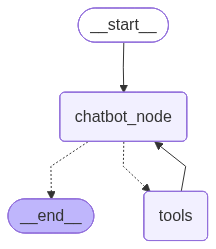

In [ ]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
config = {'configurable': {'thread_id': '1'}}

In [15]:
response = graph.invoke({"messages": [{"role": "user", "content": "i want 20 AMZN stocks and 15 MSFT stock. what will be the total cost?"}]}, config=config)
print(response["messages"][-1].content)

The total cost will be (20 * 89.9) + (15 * 200.34) = 1798 + 3005.1 = 4803.1.


In [16]:
response = graph.invoke({"messages": [{"role": "user", "content": "i want 10 AMZN stocks price and add it to previous total cost?"}]}, config=config)
print(response["messages"][-1].content)

The price of 10 AMZN stocks is 10 * 89.9 = 899. 
The previous total cost was 4803.1, so the new total cost will be 4803.1 + 899 = 5702.1.
